# NLP project


Project 21: Automatic Summarization  

We shall consider structured document containing a title, abstract and a set of subsections. We would like to build a text summarizer such that tracks important keywords in the document. For this purpose, the first step is identify these keywords.  

In [ ]:
pip install --upgrade pip

In [ ]:
!pip list
# tarkista löytyykö: lxml, html5lib, requests, selenium, webdriver-manager
# lisäohjeita task1

In [1]:
#jos nltk ei löydy asenna -> ! pip install nltk
import nltk
nltk.download("stopwords")
#from nltk.cluster.util import cosine_distance

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Markus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## TASK 1
Assume the initial input is given as html document (choose an example of your own), we hypothesize that important keywords are initially contained in the words of titles, abstract and possibly titles of subsections of the document. Suggest a simple python script that inputs an html document and outputs the lists of words in the title, abstract and title of section/subsections.

In [2]:
from bs4 import BeautifulSoup
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from nltk.tokenize import sent_tokenize
import time
# Kaikki sivut ei anna koko html bodyä käyttämällä pelkkää requestia. Seleniumilla näyttää toimivan useammilla. 
# pip install -U selenium
# pip install webdriver-manager
# jos käytät anacondaa eikä meinaa toimia niin kokeile myös $ conda update pip

# Collect title, subtitles, abstract and body text from html file.
# Print out titles and abstract and construct one string based on
# the elements.

def _convertHtmlToStr(elements):
    str = ""
    for element in elements:
        if len(element.text.split()) > 1:
            str += element.text
            if not str.endswith("."):
                str += "."
            str += " "
    sentences = sent_tokenize(str)
    return str, len(sentences)

def scrape_article(url):
    article = ""
    driver = webdriver.Chrome(ChromeDriverManager().install())
    driver.get(url)

    # Wait for article to fully load
    time.sleep(3)

    soup = BeautifulSoup(driver.page_source, 'lxml')
    strElement = ""
    countTitle, countAbstract, countH2, countH3, countH4, countP = 0, 0, 0, 0, 0, 0

    strElement, countTitle = _convertHtmlToStr(soup.find("h1", {"class": "document-title"}))
    print("Title:\n{}\n\n".format(strElement))
    article += strElement
    article += ". "
    strElement, countAbstract = _convertHtmlToStr(soup.find("div", {"class": "abstract-text"}))
    print("Abstract:\n{}\n\n".format(strElement))
    article += strElement

    articleHtmlBody = soup.find("div", {"id": "article"})
    if articleHtmlBody == None:
        raise ValueError

    strElement, countH2 = _convertHtmlToStr(articleHtmlBody.find_all("h2"))
    print("Section titles:\n{}\n\n".format(strElement))
    article += strElement
    strElement, countH3 = _convertHtmlToStr(articleHtmlBody.find_all("h3"))
    print("Subsection titles:\n{}\n\n".format(strElement))
    article += strElement
    strElement, countH4 = _convertHtmlToStr(articleHtmlBody.find_all("h4"))
    print("Subsubsection titles:\n{}\n\n".format(strElement))
    article += strElement
    strElement, countP = _convertHtmlToStr(articleHtmlBody.find_all("p"))
    article += strElement
    countP += 1

    driver.close()

    counts = [countTitle, countAbstract, countH2, countH3, countH4, countP]
    return article, counts

url = "https://ieeexplore.ieee.org/document/6809191"
article, counts = scrape_article(url)

[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 95.0.4638
[WDM] - Get LATEST driver version for 95.0.4638
[WDM] - Driver [C:\Users\Markus\.wdm\drivers\chromedriver\win32\95.0.4638.54\chromedriver.exe] found in cache
C:\Users\Markus\anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: executable_path has been deprecated, please pass in a Service object


Title:
Scalable Nearest Neighbor Algorithms for High Dimensional Data. 


Abstract:
 Abstract:For many computer vision and machine learning problems, large training sets are key for good performance. However, the most computationally expensive part of many computer vision and machine learning algorithms consists of finding nearest neighbor matches to high dimensional vectors that represent the training data. We propose new algorithms for approximate nearest neighbor matching and evaluate and compare them with previous algorithms. For matching high dimensional features, we find two algorithms to be the most efficient: the randomized k-d forest and a new algorithm proposed in this paper, the priority search k-means tree. We also propose a new algorithm for matching binary features by searching multiple hierarchical clustering trees and show it outperforms methods typically used in the literature. We show that the optimal nearest neighbor algorithm and its parameters depend on the data se

In [3]:
import yake

In [4]:
#Keyword search and analysis

w_extractor = yake.KeywordExtractor()

language = "en"
max_ngram_size = 2
deduplication_threshold = 0.9
numOfKeywords = 50 #alunperin 10

custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)
keywords = custom_kw_extractor.extract_keywords(article)

for kw in keywords:
    print(kw)


('Nearest Neighbor', 0.000448337246055043)
('Neighbor Search', 0.0007203790943328738)
('search', 0.001004904396729257)
('data set', 0.0012469099024782296)
('Data', 0.001556920030819596)
('data sets', 0.0016365692470026764)
('Neighbor', 0.002061016261751991)
('Nearest', 0.0021167328285612947)
('tree', 0.002195809492801172)
('k-means tree', 0.0027180714963474274)
('search k-means', 0.0027209590239161492)
('algorithm', 0.0028593265650193665)
('priority search', 0.003149722165786221)
('Algorithms', 0.0046464056681564695)
('neighbor algorithm', 0.004691055125189331)
('approximate nearest', 0.004897135668102593)
('set', 0.005054260810840441)
('trees', 0.0058554919808031245)
('search algorithms', 0.005962405598626943)
('neighbors', 0.0061094410616219725)
('search performance', 0.006126923659235143)
('search time', 0.006168996994115662)
('neighbor matching', 0.006372481957572293)
('Tree Algorithm', 0.00745020662968025)
('sets', 0.007581391216260663)
('approximate search', 0.0078029232970523625

## TASK 2
Write down a simple python script that allows you to output the histogram of word frequency in the document, excluding the stopwords (see examples in online NLTK book). Use SpaCy named-entity tagger to identify person-named entities and organization-named entities in the document.

In [5]:
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
from nltk.tokenize import word_tokenize
from collections import Counter

all_stopwords = stopwords.words('english')
all_stopwords.append('The')

In [6]:
text_tokens = word_tokenize(article)
tokens_without_sw = [word for word in text_tokens if word.isalpha() and word not in all_stopwords]

print(tokens_without_sw)
#print(filtered_sentence)

['Scalable', 'Nearest', 'Neighbor', 'Algorithms', 'High', 'Dimensional', 'Data', 'Abstract', 'For', 'many', 'computer', 'vision', 'machine', 'learning', 'problems', 'large', 'training', 'sets', 'key', 'good', 'performance', 'However', 'computationally', 'expensive', 'part', 'many', 'computer', 'vision', 'machine', 'learning', 'algorithms', 'consists', 'finding', 'nearest', 'neighbor', 'matches', 'high', 'dimensional', 'vectors', 'represent', 'training', 'data', 'We', 'propose', 'new', 'algorithms', 'approximate', 'nearest', 'neighbor', 'matching', 'evaluate', 'compare', 'previous', 'algorithms', 'For', 'matching', 'high', 'dimensional', 'features', 'find', 'two', 'algorithms', 'efficient', 'randomized', 'forest', 'new', 'algorithm', 'proposed', 'paper', 'priority', 'search', 'tree', 'We', 'also', 'propose', 'new', 'algorithm', 'matching', 'binary', 'features', 'searching', 'multiple', 'hierarchical', 'clustering', 'trees', 'show', 'outperforms', 'methods', 'typically', 'used', 'literat

[('search', 144), ('data', 121), ('tree', 85), ('nearest', 83), ('neighbor', 77), ('using', 57), ('algorithm', 56), ('set', 51), ('performance', 42), ('algorithms', 37), ('time', 37), ('In', 36), ('sets', 34), ('used', 34), ('randomized', 33), ('number', 33), ('trees', 32), ('approximate', 31), ('memory', 31), ('points', 30), ('We', 29), ('priority', 29), ('clustering', 27), ('neighbors', 27), ('query', 27), ('q', 27), ('features', 26), ('large', 24), ('All', 24), ('Fig', 24), ('point', 23), ('matching', 22), ('multiple', 22), ('case', 22), ('Show', 21), ('hierarchical', 20), ('different', 19), ('cluster', 19), ('many', 18), ('one', 18), ('parameter', 18), ('use', 18), ('LSH', 18), ('FLANN', 17), ('also', 16), ('patches', 16), ('P', 16), ('K', 16), ('hashing', 16), ('dimensionality', 16), ('found', 16), ('build', 16), ('speedup', 16), ('θ', 16), ('parameters', 15), ('best', 15), ('distributed', 15), ('results', 15), ('machines', 15), ('machine', 14), ('propose', 14), ('random', 14), ('

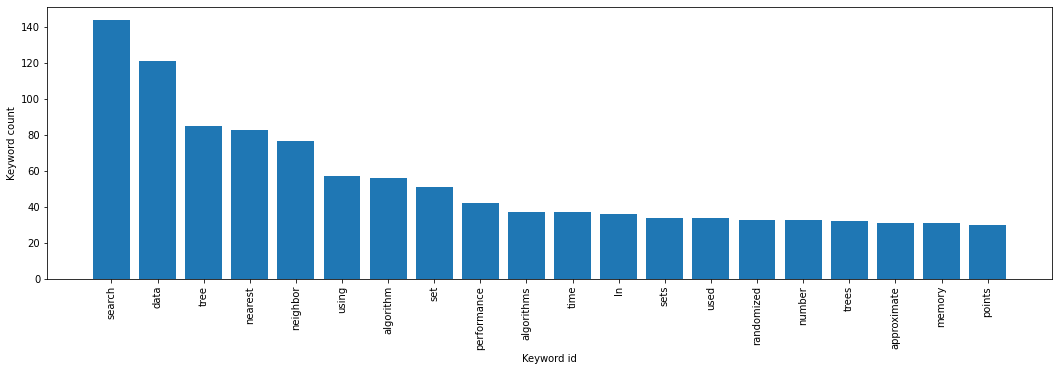

In [7]:

### Count histogram from every word manually ###
#charsToRemove = ".,()"
#wordCounts = Counter(tokens_without_sw)
wordCounts = Counter(tokens_without_sw)
wordCounts = wordCounts.most_common()

print(wordCounts)

wordCounts = wordCounts[0:20]

words = list(zip(*wordCounts))[0]
occurency = list(zip(*wordCounts))[1]
fig, ax = plt.subplots(figsize=(18,5))
plt.bar(np.arange(len(words)), occurency, align='center')
plt.xticks(np.arange(len(words)), words, rotation='vertical')
plt.ylabel('Keyword count')
plt.xlabel('Keyword id')
plt.show()

In [8]:
#Use SpaCy to identify person-named entities and organization-named entities
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm

#vinkkiä https://towardsdatascience.com/named-entity-recognition-with-nltk-and-spacy-8c4a7d88e7da

#Identifying person and organization-named entities
wordsInStr = ""
for word in tokens_without_sw:
    wordsInStr += word
    wordsInStr += " "
    
nlp = en_core_web_sm.load()
doc = nlp(wordsInStr)

#Print only ORG or PERSON labeled entities
if doc.ents:
    for ent in doc.ents:
        if ent.label_ == "ORG" or ent.label_ == "PERSON":
            print(ent.text+ " - " + ent.label_)
else:
    print("No named entities found.")

NCC - ORG
NN - ORG
NN - ORG
KNN - ORG
RNN - ORG
KNN - ORG
P K View Source KNN - ORG
RKNN - ORG
RKNN - ORG
Variations - ORG
Leibe - PERSON
Schindler - PERSON
Jégou - PERSON
Babenko Lempitsky - PERSON
LSH - ORG
Variants LSH LSH - ORG
LSH Forest - ORG
LSH - ORG
Nearest - ORG
Wang - PERSON
Bawa - PERSON
LSH Forest - ORG
downhill simplex - PERSON
Bergstra Bengio - PERSON
Exact - PERSON
Fig - PERSON
Fig - ORG
Fig - PERSON
ORB - ORG
Hamming - ORG
Depending - PERSON
Section Data - ORG
Fig - ORG
Fig - ORG
Fig - PERSON
Fig - PERSON
Trevi - PERSON
Trevi Fountain - PERSON
Fig - PERSON
SIFT - ORG
SIFT - PERSON
Fig - PERSON
Fig ANN - PERSON
Comparison - ORG
SIFT - ORG
Trevi Fountain - ORG
SIFT SURF - PERSON
ORB - ORG
Fig - ORG
SIFT SURF - PERSON
ORB - ORG
ORB - ORG
Fig LSH - PERSON
Comparison - ORG
Fitting - ORG
N - ORG
MPI - ORG
Fig - PERSON
MPI - ORG
Aly - PERSON
LSH - ORG
MPI - ORG
Fig - ORG
MPI - ORG
Fig - PERSON
Fig - ORG
Direct - ORG
Fig - ORG
N - ORG
N times - ORG
Fast Library Approximate Nea

## TASK 3

We would like the summarizer to contain frequent wording (excluding stopwords) and as many named-entities as possible. For this purpose, use the following heuristic to construct the summarizer. First we shall assume each sentence of the document as individual sub-document. Use TfIdf vectorizer to output the individual tfidef score of each word of each sentence (after initial preprocessing and wordnet lemmatization stage). Then consider only sentences that contain person or organization named-entities and use similar approach to output the tfidf score of the named-entities in each sentence. Finally construct the sentence (S) weight as a  weighted sum:
<br>
$$S_{weight}=\sum_{w\varepsilon S}W_{TfiDf}+2\sum_{NM\varepsilon S}NM_{TfiDf}+POS_s$$
<br>
where NMTfiDF stands for the TfIdF of named-entity NM in sentence S.  POSS corresponds to the sentence weight associated to the location of the sentence. So that the sentence location weight will be maximum (1) if located in the title of the document, 0.5 if located  in the title of one of the subsection, 0.25 if located in the title one of the subsubsection, 0.1 if located in one representative object of the document, and 0 if located only in the main text. Make sure to normalize the term tfidf and Nm tfidf weights and suggest a script to implement the preceding accordingly, so that the summarizer will contain the 10 sentences with the highest Sweight scores.  


In [9]:
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Markus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Markus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
weights = {
    "1": 1,
    "2": 0.1,
    "3": 0.5,
    "4": 0.25,
    "else": 0.0
}

In [11]:
def _calculateFullScores(sentenceScores, namedEntityScores, counts):
    scaler = MinMaxScaler()
    weightList= []

    if len(counts) > 0:
        if counts[2] == 0:
            counts.pop[2]
    else:
        counts = [0, 0, 0, 0, len(sentenceScores)]

    for i in range(len(counts)):
        for j in range(counts[i]):
            if i > 3:
                weightList.append(weights["else"])
            else:
                weightList.append(weights[str(i+1)])

    df = pd.DataFrame({
        "Weights": weightList,
        "SentenceScores": sentenceScores,
        "EntityScores": namedEntityScores,
    })

    df[["SentencesScaled"]] = scaler.fit_transform(df[["SentenceScores"]])
    df[["EntitiesScaled"]] = scaler.fit_transform(df[["EntityScores"]])
    df["S_weight"] = df["SentencesScaled"] + (2 * df["EntitiesScaled"]) + df["Weights"]

    return df["S_weight"].tolist()


def _getNamedEntities(article):
    nlp = en_core_web_sm.load()
    doc = nlp(article)
    namedEntities = []
    
    for ent in doc.ents:
        if ent.label_ == "ORG" or ent.label_ == "PERSON":
                namedEntities.append(ent.text)

    return namedEntities


def _getSentencesWithMaxWeights(weights, sentences, numberOfSentences):
    arr = np.array(weights)
    indexes = np.argpartition(arr, -numberOfSentences)[-numberOfSentences:]
    sentences = np.array(sentences)
    return sentences[indexes]


def _preProcess(document):
    stopwords = list(set(nltk.corpus.stopwords.words('english')))
    WN_lemmatizer = WordNetLemmatizer()
    sentences = sent_tokenize(document)
    processedSentences = []
    tokens = []

    for sentence in sentences:
        words = word_tokenize(sentence)
        words = [WN_lemmatizer.lemmatize(word, pos="v") for word in words]

        # get rid of numbers and Stopwords
        words = [word for word in words if word.isalpha() and word not in stopwords]
        processedSentences.append(' '.join(word for word in words))
        tokens.extend(words)

    return processedSentences, tokens


def _tfidfScores(corpus, sentences):
    tfidf = TfidfVectorizer()
    fittedVectorizer = tfidf.fit(corpus)
    vectors = fittedVectorizer.transform(sentences).toarray()

    scores = []
    for i in range(len(vectors)):
        score = 0
        for j in range(len(vectors[i])):
            score = score + vectors[i][j]

        scores.append(score)
    return scores

In [12]:
def findTopSentences(document, numberOfSentences, isUrl):
    sentences, tokens = _preProcess(document)
    sentenceTfidfScores = _tfidfScores(tokens, sentences)
    namedEntitiesTfidfScores = _tfidfScores(_getNamedEntities(document), sentences)
    if isUrl:
        SWeight = _calculateFullScores(sentenceTfidfScores, namedEntitiesTfidfScores, counts)
    else:
        SWeight = _calculateFullScores(sentenceTfidfScores, namedEntitiesTfidfScores, [])
    topSentences = _getSentencesWithMaxWeights(SWeight, sent_tokenize(document), numberOfSentences)
    return list(topSentences)

topSentences = findTopSentences(article, 10, True)
for sentence in topSentences:
    print("{}\n".format(sentence))

Our experiments have revealed that the optimal algorithm for approximate nearest neighbor search is highly dependent
 on several factors such as the data dimensionality, size and structure of the data set (whether there is any
 correlation between the features in the data set) and the desired search precision.

For the comparison we use a combination of both vector features such as SIFT, SURF, image patches and
 binary features such as BRIEF and ORB.

After evaluating many different algorithms for approximate nearest neighbor search on data sets with a wide range of
 dimensionality [14][47], we have
 found that one of two algorithms gave the best performance: the priority search k-means tree or
 the multiple randomized k-d trees.

We show that the optimal nearest neighbor algorithm and its parameters depend on the data set characteristics and describe an automated configuration procedure for finding the best algorithm to search a particular data set.

Scalable Nearest Neighbor Algorith


## TASK 4
Test the above approach with Opinosis dataset available at https://kavita-ganesan.com/opinosis-opinion-dataset/#.YVw6J5ozY2x,  and record the corresponding Rouge-2 and Rouge-3 evaluation score. 

In [13]:
#Rouge 2 ja 3 scoring
#https://towardsdatascience.com/the-ultimate-performance-metric-in-nlp-111df6c64460


In [14]:
#pip install git+git://github.com/bdusell/rougescore.git

'''
In ROUGE, a "peer" summary produced by a machine summarization system is compared against 
one or more hand-written "model" summaries and then assigned a score from 0 to 1. This score is the
F-measure of recall vs. precision, and the evaluator can adjust a parameter α to control whether this 
score favors recall (does the peer summary contain all of the information in the model summaries?) 
or precision (does the peer summary contain only information in the model summaries?). 

When α ≈ 0, this score favors recall; when α ≈ 1, it favors precision. 
In the DUC conferences, α was set to 0, and a hard length limit was imposed on generated summaries. 
The original ROUGE implementation uses α = 0.5 by default.
'''



'\nIn ROUGE, a "peer" summary produced by a machine summarization system is compared against \none or more hand-written "model" summaries and then assigned a score from 0 to 1. This score is the\nF-measure of recall vs. precision, and the evaluator can adjust a parameter α to control whether this \nscore favors recall (does the peer summary contain all of the information in the model summaries?) \nor precision (does the peer summary contain only information in the model summaries?). \n\nWhen α ≈ 0, this score favors recall; when α ≈ 1, it favors precision. \nIn the DUC conferences, α was set to 0, and a hard length limit was imposed on generated summaries. \nThe original ROUGE implementation uses α = 0.5 by default.\n'

In [15]:
import rougescore as rouge

def getRouge(peer, model):
    rougeBi = rouge.rouge_2(peer, model, 1)
    print("Rouge 2: ", rougeBi)
    rougeTri = rouge.rouge_3(peer, model, 1)
    print("Rouge 3: ", rougeTri)
    
    return rougeBi,rougeTri

In [16]:
def read_folder(dir):
    
    topic = []
    
    for file in os.listdir(dir):   
        with open(os.path.join(dir + file)) as f:
            doc = f.readlines()
            f.close()
            doc = " ".join(doc)
            topic.append(doc)
            
    return topic           

def create_model(dir):
    
    model = []
    
    for folder in os.listdir(directory + "summaries-gold/"):
        
        gold = read_folder(directory + "summaries-gold/" + folder + "/")
        model.append(gold)
        
    
    return model

In [17]:
def summary(dir):
    
    list_summary = []
    for file in os.listdir(directory + "topics/"):
            
        with open(os.path.join(dir + "topics/" + file)) as f:
            doc = f.readlines()
            f.close()
            doc = " ".join(doc)
            
            summary = findTopSentences(doc, 10, False)
            list_summary.append(summary)
            
    return list_summary


In [18]:
import os

directory = "C:/Users/Markus/Documents/studies/NLP/data/Opinosis_dataset/"

summary = summary(directory)
model = create_model(directory)

In [19]:
#lause = ""
#for senctence in summary:
#    lause += sentence

#malli = ["The battery life of the ipod nano is very short. It seems to continue", "using battery even when the ipod is not in use, otherwise, it's a great product."]
#result = rouge.rouge_2(lause, model, 1)
#print(result)

In [20]:
#summary = ['It has worked well for local driving giving accurate directions for roads and streets .', ",  Very Accurate but with one small glitch I found ,  I'll explain in the CONS\n This is a great GPS, it is so easy to use and it is always accurate .", 'The Garmin is loaded with very accurate maps that generally know the roads in even the remotest areas .', "I used it the day I bought it,   and then this morning, and as soon as it comes on it is  ready to navigate  The only downfall of this product, and the only reason I did not give it 5 stars is the fact that the speed limit it displays for the road you are on isn't 100% accurate .", 'Depending on what you are using it for, it is a nice adjunct to a travel trip and the directions are accurate and usually the quickest, but not always .', "I'm really glad I bought it though, and like the easy to read graphics, the voice used to tell you the name of the street you are to turn on, the uncannily accurate estimates of mileage and time of arrival at your destination .", 'My new Garmin 255w had very Easy Set Up, Accurate Directions to locations, User Friendly Unit to anyone in my vehicle who tried it .', 'In closing, this is a fantastic GPS with some very nice features and is very accurate in directions .', 'but for the most part, we find that the Garmin software provides accurate directions, whereever we intend to go .', '0 out of 5 stars Inexpensive, accurate, plenty of features, August 6, 2009\n  The only glitch I have found so far is that the speed limits are not 100% accurate, although the GPS, amazingly, is able to very accurately tell you how fast your vehicle is moving .']
#summary = " ".join(summary)
#print(type(summary))
#model = ['This unit is generally quite accurate.  \n Set-up and usage are considered to be very easy. \n The maps can be updated, and tend to be reliable.\n', "The Garmin seems to be generally very accurate.\n It's easy to use with an intuitive interface.", 'It is very accurate, even in destination time.\n', 'Very accurate with travel and destination time.\n Negatives are not accurate with speed limits and rural roads.', 'Its accurate, fast and its simple operations make this a for sure buy.']
#bi, tri = getRouge(summary, model)

In [21]:
list_score = []

for i in range(len(summary)):
    summary_str = " ".join(summary[i])
    bi, tri = getRouge(summary_str, model[i])
    list_score.append((bi,tri))

Rouge 2:  0.0521415270018622
Rouge 3:  0.04161490683229813
Rouge 2:  0.06709401709401709
Rouge 3:  0.05205772314270444
Rouge 2:  0.06591880341880342
Rouge 3:  0.0518439337252806
Rouge 2:  0.05249376558603491
Rouge 3:  0.038053649407361195
Rouge 2:  0.045127670661803024
Rouge 3:  0.03388946819603754
Rouge 2:  0.04378980891719745
Rouge 3:  0.032982791586998086
Rouge 2:  0.07489539748953974
Rouge 3:  0.057780879274249825
Rouge 2:  0.04680511182108626
Rouge 3:  0.03788968824940048
Rouge 2:  0.06344676180021953
Rouge 3:  0.04470071389346513
Rouge 2:  0.04062976130015236
Rouge 3:  0.029268292682926828
Rouge 2:  0.05088339222614841
Rouge 3:  0.03559222156747201
Rouge 2:  0.03131808278867102
Rouge 3:  0.02425068119891008
Rouge 2:  0.05612244897959184
Rouge 3:  0.04238861386138614
Rouge 2:  0.05408932714617169
Rouge 3:  0.04294834590829948
Rouge 2:  0.034907161803713525
Rouge 3:  0.026539278131634817
Rouge 2:  0.07409200968523003
Rouge 3:  0.058873410054512416
Rouge 2:  0.043626806833114325
Rou

In [22]:
print(list_score)

[(0.0521415270018622, 0.04161490683229813), (0.06709401709401709, 0.05205772314270444), (0.06591880341880342, 0.0518439337252806), (0.05249376558603491, 0.038053649407361195), (0.045127670661803024, 0.03388946819603754), (0.04378980891719745, 0.032982791586998086), (0.07489539748953974, 0.057780879274249825), (0.04680511182108626, 0.03788968824940048), (0.06344676180021953, 0.04470071389346513), (0.04062976130015236, 0.029268292682926828), (0.05088339222614841, 0.03559222156747201), (0.03131808278867102, 0.02425068119891008), (0.05612244897959184, 0.04238861386138614), (0.05408932714617169, 0.04294834590829948), (0.034907161803713525, 0.026539278131634817), (0.07409200968523003, 0.058873410054512416), (0.043626806833114325, 0.034845496383957925), (0.04647599591419816, 0.036177823198773634), (0.0725883476599809, 0.04990439770554493), (0.09107981220657277, 0.0678151918559123), (0.05964035964035964, 0.04737631184407796), (0.038120567375886524, 0.03180435884439939), (0.05420118343195266, 0

In [23]:
import dataframe_image as dfi

df = pd.DataFrame(list_score)
df.columns=['rouge2', 'rouge3']
#df.rename(columns={'0': })
df.loc['mean'] = df.mean()
df.columns.names = ['topic number']
df
#dfi.export(df, 'dataframe.png')
#df.mean(axis=0)
#for list_score in list_scores:
#    df

## TASK 5

[x] We would like to improve the summarization by taking into account the diversity among the sentence in the sense that we would like to minimize redundancy among sentences. For this purpose, we shall use the sentence-to-sentence semantic similarity introduced in the NLP lab. 

[x] Next, instead of recording only the 10 sentences with highest Sweight scores, we shall record the 20 top sentences in terms of $S_{weight}$ scores. Then the selection of the top 10 sentences among the 20 sentences follows the following approach. 

[x] First, order the 20 sentences in the decreasing order of their $S_{weight}$ scores, say S1, S2, …, S20 (where S1 is the top ranked and S20 the 20th ranked sentence). 

[x] Second, we shall assume that S1 is always included in the summarizer, we shall then attempt to find the other sentences among S2 till S20 to be included into the summarizer. 

[x] Calculate the sentence-to-sentence similarity Sim(S1,Si) for i=1 to 20, the Sentence Sj that yields the minimum similarity with S1 will therefore be included in the summarizer. 

[x] Next, for each of the remaining sentences Sk (with k different from 1 and j), we calculate the sentence similarity with Sj. Therefore the sentence Sp that yields minimum value of “Sim(Sp, S1)+Sim(Sp,Sj)” will be included in the summarizer (Note: the quantity Sim(Sp, S1) is already calculated in previous step).  

[x] Similarly in the next phase, we should select a sentence Sl (l different from 1, j and k) so that  “Sim(Sl, S1)+Sim(Sl,Sj)+Sim(Sl,Sp)”, Etc.. 

[x] You then stop once you reached 10 sentences included in the summarizer. 

[ ] Suggest a script that includes this process.. and illustrate its functioning in the example you chosen in 1).

In [ ]:
#kirjoitan tähän itselleni että pysyn ohjeiden perässä
#1.Luo 20 lauseen lista, missä lauseiden s(weight) pisteet ovat suurimmat (s1,s2,s3,...,s20)
#2.s1 on tiivistelmän ensimmäinen lause 
#    2.1 poista s1 listalta
#3.Vertaa loppuja lauseita s1. Lause joka on vähiten samanlainen s1 kanssa lisätään tiivistelmään, ja kutsutaan s(j)
#    3.1 poista s(j) listalta
#4.Vertaa loppuja lauseita s(j) ja taas alin arvo lisätään tiivistelmään. Lisätty lause s(p)
#    4.1 poista lause

In [ ]:
#print(len(sentences))

In [ ]:
#download larger pipeline package for spaCy
#python -m spacy download en_core_web_lg #tarkempi mutta 770mb kokoinen

#python -m spacy download en_core_web_sm #paljon pienempi mutta ei yhtä tarkka

In [24]:
#s1 määritys
def find_first_sentence(sentences):
    picked_sentences = []

    #choose dictionary
    nlp = spacy.load("en_core_web_sm")
    #nlp = spacy.load("en_core_web_md")

    #löydä ensimmäinen lause, korkein s(weigth)
    for sentence in sentences: 
        #lisää koodi s(weight) laskemiseen, tai valitse ensimmäinen lause jos lista on järjestyksessä
        s1 = sentence

    #poista valinta listasta ja lisää tiivistelmä listaan    
    picked_sentences.append(s1)
    sentences.remove(s1)

    print(picked_sentences)
    return picked_sentences

In [26]:
#Loppujen yhdeksän lauseen valinta
def sentence_to_sentence(sentences):
#lista samanlaisuus pisteistä
    sim_score = []
    picked_sentences = find_first_sentence(sentences)
    #while pyörii kunnes 10 lausetta on löydetty
    while(len(picked_sentences)<10):
        sim_score.clear()

        for sentence in sentences:
            nlp_sentence = nlp(str(sentence))
            score = 0

            for p_sentence in picked_sentences:
                #vertaa kahta lausetta
                nlp_p_sentence = nlp(str(p_sentence))

                score += nlp_p_sentence.similarity(nlp_sentence)

            sim_score.append(score)


        print(sim_score)
        min_value = min(sim_score)
        min_index = sim_score.index(min_value)   

        print("Sentences left in the list: " + str(len(sentences)))
        print("Smallest value: " + str(min_value))
        print(sentences[min_index])

        picked_sentences.append(sentences[min_index])
        sentences.remove(sentences[min_index])
    return picked_sentences

picked_sentences = sentence_to_sentence(findTopSentences(article, 20, True))

['The partitioning of the data set into independent subsets, as described above and implemented in FLANN, has the\n advantage that it doesn’t depend on the type of index used (randomized kd-trees, priority search k-means tree,\n hierarchical clustering, LSH) and can be applied to any current or future nearest neighbor algorithm in FLANN.']


C:\Users\Markus\anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.


[0.643861550105796, 0.5028268063107327, 0.7322534859727825, 0.663930511385731, 0.6335904544092588, 0.6983835592201584, 0.622118457505475, 0.4401745828121053, 0.5762596271229163, 0.6523423887535276, 0.7360174665545778, 0.6829561835694372, 0.6393883659146156, 0.5333326103698475, 0.42252652644148997, 0.6780301642254263, 0.7962834825090873, 0.6396972923799609, 0.6064917099697087]
Sentences left in the list: 19
Smallest value: 0.42252652644148997
Scalable Nearest Neighbor Algorithms for High Dimensional Data.
[0.8588201822113241, 0.8090994928151842, 1.116702113022128, 0.9964958721438267, 0.9089299138617903, 1.1250272215241606, 0.9947831006405559, 0.8128338248561437, 0.876445044105516, 1.0860537154974677, 1.0385956804130738, 1.1911751204516392, 0.9707476217801154, 0.8858559461157092, 0.997710305284621, 1.1926906328104425, 0.9516025097491644, 0.978312247820341]
Sentences left in the list: 18
Smallest value: 0.8090994928151842
For the comparison we use a combination of both vector features suc

In [27]:
print("Summarized text")
print(picked_sentences)

Summarized text
['The partitioning of the data set into independent subsets, as described above and implemented in FLANN, has the\n advantage that it doesn’t depend on the type of index used (randomized kd-trees, priority search k-means tree,\n hierarchical clustering, LSH) and can be applied to any current or future nearest neighbor algorithm in FLANN.', 'Scalable Nearest Neighbor Algorithms for High Dimensional Data.', 'For the comparison we use a combination of both vector features such as SIFT, SURF, image patches and\n binary features such as BRIEF and ORB.', 'We also propose a new algorithm for matching binary features by searching multiple hierarchical clustering trees and show it outperforms methods typically used in the literature.', 'We have found the randomized k-d forest to be very effective in many situations, however on other data sets a\n different algorithm, the priority search k-means tree, has been more effective at finding approximate\n nearest neighbors, especially 

## TASK 6

We would like to make the choice of keywords not based on histogram frequency but using the open source RAKE https://www.airpair.com/nlp/keyword-extraction-tutorial. Repeat the previous process of selecting the sentences that are associated to the ten first keywords generated by RAKE. Comment on the quality of this summarizer based on your observation

In [ ]:
#Repossa ollut asennus tiedosto ei kyennyt asentumaan windows ympäristössä ilman korjausta
#git clone https://github.com/zelandiya/RAKE-tutorial
#cd RAKE-tutorial

#Ennen asennusta mene setup.py tiedostoon ja poista slash (/) poluista: 
#package_dir={'nlp_rake': './'} ja 
#package_data={'nlp_rake': ['data/']}

#muutin "nlp-rake" nimen pelkäksi "rake" asennus tiedostossa.

#kuva setup_korjaus löytyy githubista, jonka jälkeen paketin asennus toimii
#python setup.py install 



In [ ]:
#Asensin moduulin eri paikkaan kuin missä jupyter serveri polku, korjasin tällä polun
import sys 
sys.path.append("C:/Users/Markus/Documents/studies/NLP/RAKE-tutorial")

In [ ]:
import rake 
import operator

In [ ]:
#Korjaa polku, tiedosto löytyy githubista
rake_object = rake.Rake("C:/Users/Markus/Documents/studies/NLP/NLP/SmartStoplist.txt", 5, 3, 4) 

In [ ]:
#sample_file = open("C:/NLP/RAKE-tutorial/data/docs/fao_test/w2167e.txt", 'r') #aseta teksti minkä haluat käsitellä
#text = sample_file.read()
sentenceList = rake.split_sentences(article)
print(sentenceList[0:1])


In [ ]:
keywords = rake_object.run(article)
#print("Keywords:", keywords[0:10]) #10 ensimmäistä
keywords_topten = []

for i in range(10):
    keywords_topten.append(keywords[i][0])
    
print(keywords_topten)

In [ ]:
#extract sentences using keywords
dct = {}
for sentence in sentenceList:
    dct[sentence] = sum(1 for word in keywords_topten if word in sentence)

rake_sentences = [key for key,value in dct.items() if value == max(dct.values())]


print("\n".join(rake_sentences))

In [ ]:
#Comparing results
print("Sentences in original text: {}, summarized amount: {}".format(len(sentenceList),len(rake_sentences)))

In [ ]:
Comment on results:

## TASK 7

It is also suggested to explore alternative implementations with larger number of summarization approaches implemented- https://github.com/miso-belica/sumy. Show how each of the implemented summarizer behaves when inputted with the same document you used in previous case.

In [ ]:
#https://github.com/miso-belica/sumy
#pip install sumy

In [28]:
from sumy.parsers.html import HtmlParser
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer as LSASummarizer
from sumy.summarizers.lex_rank import LexRankSummarizer as LexRankSummarizer
from sumy.summarizers.luhn import LuhnSummarizer as LuhnSummarizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words

LANGUAGE = "english"
SENTENCES_COUNT = 10

In [29]:
def sumySummarize(article):
    stemmer = Stemmer(LANGUAGE)
    summarizers = [LexRankSummarizer(stemmer), LSASummarizer(stemmer), LuhnSummarizer(stemmer)]
    parser = PlaintextParser.from_string(article, Tokenizer(LANGUAGE))
    results = []
    
    for summarizer in summarizers:
        summarizer.stop_words = get_stop_words(LANGUAGE)
        sentences = []
        for sentence in summarizer(parser.document, SENTENCES_COUNT):
            sentences.append(sentence)
        results.append(sentences)
    
    return results

sumySentences = sumySummarize(article)
for sentences in sumySentences:
    print("{}\n\n".format(sentences))

[<Sentence: 2.1 Nearest Neighbor Matching Algorithms.>, <Sentence: After evaluating many different algorithms for approximate nearest neighbor search on data sets with a wide range of dimensionality [14][47], we have found that one of two algorithms gave the best performance: the priority search k-means tree or the multiple randomized k-d trees.>, <Sentence: The randomized k-d tree algorithm [13], is an approximate nearest neighbor search algorithm that builds multiple randomized k-d trees which are searched in parallel.>, <Sentence: Our experiments have revealed that the optimal algorithm for approximate nearest neighbor search is highly dependent on several factors such as the data dimensionality, size and structure of the data set (whether there is any correlation between the features in the data set) and the desired search precision.>, <Sentence: We compare the two algorithms we found to be the best at finding fast approximate nearest neighbors (the multiple randomized kd-trees and

## TASK 8

Now we would like to compare the above summarizers and those in 3), 5) and 7) on a new dataset constructed as follows. First select an Elsevier journal of your own and select 10 papers highly ranked in the journal according to citation index (The journal papers should be well structured to contain Abstract, Introduction and Conclusion). 

For each of the ten papers, consider the introduction as the main document to seek to apply summarizer, and consider the Abstract and Conclusion as two golden summary of the document that you can use for assessment using ROUGE-1 and ROUGE-2 evaluation. 

Report in a table the evaluation score of each summarizer. 

In [36]:
#Rouge 1 & 2 pisteytyts koodi
articles = []
def scrape_task8_article(url):
    article = ""
    driver = webdriver.Chrome(ChromeDriverManager().install())
    driver.get(url)

    # Wait for article to fully load
    time.sleep(3)

    soup = BeautifulSoup(driver.page_source, 'lxml')
    strElement = ""
    countTitle, countAbstract, countH2, countH3, countH4, countP = 0, 0, 0, 0, 0, 0

    strElement, countTitle = _convertHtmlToStr(soup.find("h1", {"class": "document-title"}))
    #print("Title:\n{}\n\n".format(strElement))
    article += strElement
    article += ". "
    strElement, countAbstract = _convertHtmlToStr(soup.find("div", {"class": "abstract-text"}))
    #print("Abstract:\n{}\n\n".format(strElement))
    article += strElement

    articleHtmlBody = soup.find("div", {"id": "article"})
    if articleHtmlBody == None:
        raise ValueError

    strElement, countH2 = _convertHtmlToStr(articleHtmlBody.find_all("h2"))
    #print("Section titles:\n{}\n\n".format(strElement))
    article += strElement
    strElement, countH3 = _convertHtmlToStr(articleHtmlBody.find_all("h3"))
    #print("Subsection titles:\n{}\n\n".format(strElement))
    article += strElement
    strElement, countH4 = _convertHtmlToStr(articleHtmlBody.find_all("h4"))
    #print("Subsubsection titles:\n{}\n\n".format(strElement))
    article += strElement
    strElement, countP = _convertHtmlToStr(articleHtmlBody.find_all("p"))
    article += strElement
    countP += 1
    
    paragraph = ""
    for header in soup.find("div", {"id": "sec5"}):
        paragraph += header.get_text() + u'\n'
        for elem in header.next_siblings:
            #if elem.name and elem.name.startswith('h'):
                # stop at next header
            #    break
            if elem.name == 'p':
                print(elem.get_text())
                paragraph += elem.get_text() + u'\n'

    driver.close()

    counts = [countTitle, countAbstract, countH2, countH3, countH4, countP]
    return article, counts

article, counts = scrape_task8_article("https://ieeexplore.ieee.org/document/7467408")
#print(article)

[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 95.0.4638
[WDM] - Get LATEST driver version for 95.0.4638
[WDM] - Driver [C:\Users\Markus\.wdm\drivers\chromedriver\win32\95.0.4638.54\chromedriver.exe] found in cache
C:\Users\Markus\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  """


As we have demonstrated, the combination of blockchains and IoT can be pretty powerful. Blockchains give us resilient, truly distributed peer-to-peer systems and the ability to interact with peers in a trustless, auditable manner. Smart contracts allow us to automate complex multi-step processes. The devices in the IoT ecosystem are the points of contact with the physical world. When all of them are combined we get to automate time-consuming workflows in new and unique ways, achieving cryptographic verifiability, as well as significant cost and time savings in the process.
We believe that the continued integration of blockchains in the IoT domain will cause significant transformations across several industries, bringing about new business models and having us reconsider how existing systems and processes are implemented.
We believe that the continued integration of blockchains in the IoT domain will cause significant transformations across several industries, bringing about new busines

In [46]:
files = []
for i in range(1,11):
    with open('C:/Users/Markus/Documents/studies/NLP/NLP/Data/Task8_articles/article{}.txt'.format(i), encoding="utf8") as f:
        text = f.readlines()
    text = " ".join(text)
    res = text.split("\n \n")
    files.append([res[0], res[1], res[2]])


In [47]:
print(files[0][0])

Feature selection is an important task in data mining and machine learning to reduce the dimensionality of the data and increase the performance of an algorithm, such as a classification algorithm. However, feature selection is a challenging task due mainly to the large search space. A variety of methods have been applied to solve feature selection problems, where evolutionary computation (EC) techniques have recently gained much attention and shown some success. However, there are no comprehensive guidelines on the strengths and weaknesses of alternative approaches. This leads to a disjointed and fragmented field with ultimately lost opportunities for improving performance and successful applications. This paper presents a comprehensive survey of the state-of-the-art work on EC for feature selection, which identifies the contributions of these different algorithms. In addition, current issues and challenges are also discussed to identify promising areas for future research.


## TASK 9

Design a simple GUI that allows the user to input a text or a link to a document to be summarized and output the summarizer according to 3), algorithms implemented in 7)

In [ ]:
# run simpleGUI.py